In [2]:
import scipy.optimize as op
import numpy as np
mvn = np.random.multivariate_normal
import itertools
from cohlib.alg.laplace_sgc import TrialData, SpikeTrial
from scipy.linalg import block_diag

def fit_sgc_model(data, W, inits, num_em_iters=10, max_approx_iters=10, track=False):
    # safety / params
    assert type(data) is list
    K = len(data)

    Ls = [data[i].shape[0] for i in range(K)]
    L = Ls[0]
    # assert all_equal(Ls)

    num_timepts = W.shape[0]
    num_freqs = W.shape[1]

    # inits
    Gamma_inv_init = inits['Gamma_inv_init']

    # alg
    # TODO make classes NOT mutable
    for r in range(num_em_iters):
        print(f'EM iter: {r}')
        if r == 0:
            Gamma_prev_inv = Gamma_inv_init

        mus = np.zeros((L,K*num_freqs))
        Ups_invs = np.zeros((L,K*num_freqs,K*num_freqs))

        for l in range(L):
            print(f'Laplace Approx trial {l}')
            trial = get_trial_obj(data, l, W, Gamma_prev_inv)
            mu, Ups_inv = trial.laplace_approx()
            # real reprsentation
            mus[l,:] = mu
            Ups_invs[l,:,:] = Ups_inv


        # M-Step
        print(f'M-Step for EM iter {r}')
        Gamma_update_real = update_Gamma_real(mus, Ups_invs, K, num_freqs) # gamma update is only for 
        if track is True:
            track_gamma.append(Gamma_update_real)
        Gamma_prev_inv = construct_Gamma_full_real(Gamma_update_real, K, num_freqs, invert=True)

        # NEEDED?
        # real -> complex rep
        # complex -> real rep
    return Gamma_update_real

def get_trial_obj(data, l, W, Gamma_inv_prev):
    """
    data is list of spike data (trial x neurons x time)
    """
    trial_data = [group_data[l,:,:] for group_data in data]
    spike_objs = [SpikeTrial(data) for data in trial_data]
    trial_obj = TrialData(spike_objs, Gamma_inv_prev, W)
    return trial_obj
    
def update_Gamma_real(mus, Ups_invs, K, num_J_vars):
    '''
    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    '''
    L = mus.shape[0]

    J = int(num_J_vars/2)
    mus_outer = np.zeros((L,J,K*2,K*2))
    Upss = np.zeros((L,J,K*2,K*2))
    
    for l in range(L):
        Ups_inv_js = get_freq_mats_real(Ups_invs[l,:,:], K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l,:], K,num_J_vars)
        for j in range(J):
            mus_outer[l,j,:,:] = np.outer(mu_js[j], mu_js[j])
            Upss[l,j,:,:] = 1/np.diag(Ups_inv_js[j])

    Gamma_update = np.zeros((J,K*2,K*2))
    for l in range(L):
        Gamma_update += mus_outer[l,:,:,:] + Upss[l,:,:,:]
        # Gamma_update += mus_outer[l,:,:,:] 
    Gamma_update = Gamma_update / L

    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask =  1 - k_mask_inv

    # print(f'N = {N}, Gamma_update shape = {Gamma_update.shape}')
    for j in range(J):
        Gamma_update[j,:,:] = Gamma_update[j,:,:]*k_mask

    return Gamma_update

def construct_Gamma_full_real(Gamma_real, K, num_J_vars, invert=False):
    J = int(num_J_vars/2)
    Gamma_full = np.zeros((K*num_J_vars, K*num_J_vars))
    for j in range(J):
        Gamma_n = Gamma_real[j,:,:]
        if invert == True:
            Gamma_n = np.linalg.inv(Gamma_n)
        base_filt = np.zeros(num_J_vars)
        j_var = int(j*2)
        base_filt[j_var:j_var+2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        # print(j_filt)
        for k in range(K):
            kj = int(k*2)
            Gamma_full[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2] = Gamma_n[:,kj:kj+2]

    return Gamma_full

def get_freq_mats_real(group_block_matrix, K, num_J_vars):
    """
    mat is Knum_J_vars*Knum_J_vars 
    ordered as i = k*num_J_vars + j
    """
    j_mats = []
    for j_var in range(0,num_J_vars,2):
        base_filt = np.zeros((num_J_vars, num_J_vars))
        base_filt[j_var:j_var+2,j_var:j_var+2] = 1
        j_filt = np.tile(base_filt.astype(bool), (K,K))
        mat_j = group_block_matrix[j_filt].reshape(2*K,-1)
        j_mats.append(mat_j)
    return j_mats


# confirmed working
def get_freq_vecs_real(vec, K,num_J_vars):
    j_vecs = []
    for j in range(0,num_J_vars,2):
        base_filt = np.zeros(num_J_vars)
        base_filt[j:j+2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        j_vecs.append(vec_j)
    return j_vecs



# Functions for complex Gamma (UNFINISHED / UNTESTED)
# TODO get complex version from real mus/ups
def update_Gamma(mus, Ups_invs, K, num_J_vars):
    L = z_ests.shape[0]
    # gamma = np.zeros((num_J_vars,K,K))

    mus_outer = np.zeros((L,num_J_vars,K,K))
    Upss = np.zeros((L,num_J_vars,K,K))
    

    for l in range(L):
        Ups_inv_js = get_freq_mats(Ups_invs[l,:,:], K, num_J_vars)
        mu_js = get_freq_vecs(mus, K,num_J_vars)
        for j in range(num_J_vars):
            mus_outer[l,j,:,:] = np.outer(mu_js[j], mu_js[j])
            Upss[l,j,:,:] = np.linag.inv(Ups_inv_js[j])

    Gamma_update = np.sum([Upss, mus_outer], axis=0)
    return Gamma_update


# TODO fix based on complex/real rep
def get_freq_mats(group_block_matrix, K, num_J_vars):
    """
    mat is Knum_J_vars*Knum_J_vars 
    ordered as i = k*num_J_vars + j
    """
    j_mats = []
    for j in range(num_J_vars):
        base_filt = np.zeros((num_J_vars, num_J_vars))
        base_filt[j,j] = 1
        j_filt = np.tile(base_filt.astype(bool), (K,K))
        mat_j = group_block_matrix[j_filt].reshape(K,-1)
        j_mats.append(mat_j)

    return j_mats



def get_freq_vecs(vec, K,J, conv_to_complex=True):
    j_vecs = []
    for j in range(0,J,2):
        base_filt = np.zeros(J)
        base_filt[j:j+2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        if conv_to_complex:
            vec_j = conv_real_vec_j_to_complex(vec_j, K)
        j_vecs.append(vec_j)
    return j_vecs

from cohlib.utils import conv_complex_to_real
def convert_Gamma_j_complex_to_real(Gamma_j_complex):
    K = Gamma_j_complex.shape[0]
    Gamma_j_real = np.zeros((K*2,K*2))
    for k in range(K):
        c1 
        a1, b1 = conv_complex_to_real(c1)

        for k2 in range(k, K):
            a2, b2 = conv_complex_to_real(c2)

def convert_Ups_inv_js_real_to_complex(Ups_inv_j_real, K):
    Ups_inv_j_complex = np.zeros((K,K), dtype=complex)
    pre = np.diag(Ups_inv_j_real)
    for i, k in enumerate(range(0,K,2)):
        print
        Ups_inv_j_complex[i,i] = pre[k:k+2].sum()/2
    return Ups_inv_j_complex


    #TODO 
    pass




def all_equal(iterable):
    g = itertools.groupby(iterable)
    return next(g, True) and not next(g, False)

In [3]:
import numpy as np
from cohlib.utils import pickle_open
from cohlib.alg.laplace_sgc import SpikeTrial, TrialData

In [4]:
L = 25
sample_length = 1000
C = 30
seed = 8
mu = -3.5

save_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{seed}'

data_load = pickle_open(save_path)

pp_params = data_load['observed']['pp_params']
spikes1 = data_load['observed']['spikes'][0]
spikes2 = data_load['observed']['spikes'][1]

xns = data_load['latent']['xns']
xys = data_load['latent']['xys']

xnfs = data_load['latent']['xnfs']
xyfs = data_load['latent']['xyfs']
Gamma = data_load['latent']['Gamma']
true_coh = data_load['meta']['coh_true']
coh1 = data_load['meta']['coh_direct_est']

freqs = data_load['meta']['freqs']

In [9]:
xnfs.shape
J = freqs.size
K = 2
res = np.zeros((L, J, K,K), dtype=complex)
for l in range(L):
    for j in range(500):
        # z = np.array([np.sqrt(0.5)*xnfs[l,j], np.sqrt(0.5)*xyfs[l,j]])
        z = np.array([xnfs[l,j], xyfs[l,j]])
        res[l,j,:,:] = np.outer(z, z.conj())

res = res.sum(0) / L

In [10]:
j=0
print(np.round(Gamma[j,:,:], 5))
print(np.round(res[j,:,:], 5))

[[ 6.07507+0.j     -0.0454 -0.0909j]
 [-0.0454 +0.0909j  3.72462+0.j    ]]
[[13.36746-0.j      -0.06349+1.21216j]
 [-0.06349-1.21216j  6.20199+0.j     ]]


In [11]:
spikes = [spikes1, spikes2]

In [12]:
from cohlib.alg.transform import generate_harmonic_dict
sample_length = data_load['meta']['sample_length']
fs = data_load['meta']['fs']
frange = [0, int(fs/2)]
res = fs/sample_length

W = generate_harmonic_dict(sample_length, fs, res, frange)

In [13]:
num_J_vars = W.shape[1]
K = len(spikes)
Gamma_inv_init = np.eye(K*num_J_vars)

spikes_short = [spikes[i][:5,:,:] for i in range(len(spikes))]

In [14]:
# Gamma_est = fit_sgc_model(spikes_short, W, inits, num_em_iters=1, max_approx_iters=10, track=False)
data = spikes
K = len(data)

Ls = [data[i].shape[0] for i in range(K)]
L = Ls[0]
# assert all_equal(Ls)

num_timepts = W.shape[0]
num_freqs = W.shape[1]

Gamma_prev_inv = Gamma_inv_init

mus = np.zeros((L,K*num_freqs))
Ups_invs = np.zeros((L,K*num_freqs,K*num_freqs))

for l in range(L):
    print(f'Laplace Approx trial {l}')
    trial = get_trial_obj(data, l, W, Gamma_prev_inv)
    mu, Ups_inv = trial.laplace_approx()
    # real reprsentation
    mus[l,:] = mu
    Ups_invs[l,:,:] = Ups_inv

# # M-Step
# print(f'M-Step for EM iter {r}')
# Gamma_update_real = update_Gamma_real(mus, Ups_invs, K, num_freqs) # gamma update is only for 
# if track is True:
#     track_gamma.append(Gamma_update_real)
# Gamma_prev_inv = construct_Gamma_full_real(Gamma_update_real, K, num_freqs, invert=True)


Laplace Approx trial 0
Laplace Approx trial 1
Laplace Approx trial 2
Laplace Approx trial 3
Laplace Approx trial 4
Laplace Approx trial 5
Laplace Approx trial 6
Laplace Approx trial 7
Laplace Approx trial 8
Laplace Approx trial 9
Laplace Approx trial 10
Laplace Approx trial 11
Laplace Approx trial 12
Laplace Approx trial 13
Laplace Approx trial 14
Laplace Approx trial 15
Laplace Approx trial 16
Laplace Approx trial 17
Laplace Approx trial 18
Laplace Approx trial 19
Laplace Approx trial 20
Laplace Approx trial 21
Laplace Approx trial 22
Laplace Approx trial 23
Laplace Approx trial 24


In [67]:
mus.shape
L = mus.shape[0]

J = int(num_J_vars/2)
mus_outer = np.zeros((L,J,K*2,K*2))
mus_outer_c = np.zeros((L,J,K,K), dtype=complex)
Upss = np.zeros((L,J,K*2,K*2))

In [68]:
def conv_real_vec_j_to_complex(vec_j, K):
    vec_j_complex = np.zeros(int(K), dtype=complex)
    for i, k in enumerate(range(0,K+1,2)):
        a,b = vec_j[k:k+2] 
        c = conv_real_to_complex(a,b)
        vec_j_complex[i] = c
    return vec_j_complex

In [69]:
conv_real_vec_j_to_complex(mu_js[0], 2)

array([0.01610528+0.29551654j, 0.35628231+0.03045686j])

In [118]:
from cohlib.utils import conv_real_to_complex
for l in range(L):
    # Ups_inv_js = get_freq_mats_real(Ups_invs[l,:,:], K, num_J_vars)
    Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l,:,:]), K, num_J_vars)
    mu_js = get_freq_vecs_real(mus[l,:], K,num_J_vars)
    for j in range(50):
        mus_outer[l,j,:,:] = np.outer(mu_js[j], mu_js[j])
        mus_j_c = conv_real_vec_j_to_complex(mu_js[j], K)
        mus_outer_c[l,j,:,:] = np.outer(mus_j_c, mus_j_c.conj())
        # Upss[l,j,:,:] = np.diag(1/np.diag(Ups_inv_js[j]))
        Upss[l,j,:,:] = np.diag(1/Ups_inv_j_vecs[j])
base_est = mus_outer.sum(0) / L
base_est_c = mus_outer_c.sum(0) / L

In [117]:
def transform_cov_c2r(complex_cov):
    dim = complex_cov.shape[0]
    A = np.real(complex_cov)
    B = np.imag(complex_cov)
    rcov = np.zeros((2*dim, 2*dim))
    
    rcov = np.block([[A, -B],
                     [B, A]])

    return rcov/2

def transform_cov_r2c(real_cov):
    dimR = real_cov.shape[0]
    dimC = int(dimR/2)
    ccov = np.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC,:dimC]

    Re = real_cov[:dimC,:dimC]
    Im = real_cov[dimC:,:dimC]

    ccov = 2*Re + 2*1j*Im

    return ccov

def est_cov_r2c(real_cov):
    dimR = real_cov.shape[0]
    dimC = int(dimR/2)
    ccov = np.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC,:dimC]
    B = real_cov[:dimC,dimC:]
    C = real_cov[dimC:,:dimC]
    D = real_cov[dimC:,dimC:]

    ccov = (A + D) + 1j*(B - C)

    return ccov

def rearrange_mat(mat, K):
    temp = np.tile(np.array([1,0]), K)
    f1 = np.outer(temp, temp)
    f2 = np.roll(f1,1,axis=1)
    f3 = np.roll(f1,1,axis=0)
    f4 = np.roll(f1,1,axis=(0,1))

    A = mat[f1.astype(bool)].reshape(K,-1)
    B = mat[f2.astype(bool)].reshape(K,-1)
    C = mat[f3.astype(bool)].reshape(K,-1)
    D = mat[f4.astype(bool)].reshape(K,-1)
    
    new_mat = np.block([[A, B],
                       [C, D]])
    return new_mat

In [119]:
j = 1
k_mask_pre = 1 - np.eye(2)
k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
k_mask =  1 - k_mask_inv

temp = base_est[j,:,:]
rcov = rearrange_mat(temp*k_mask, K)

np.round(est_cov_r2c(rcov),5)

array([[ 0.45752+0.j     , -0.10291-0.04081j],
       [-0.10291+0.04081j,  0.54295+0.j     ]])

In [120]:
np.round(rcov, 5)

array([[ 0.27628, -0.07686, -0.     , -0.00127],
       [-0.07686,  0.3422 ,  0.03954, -0.     ],
       [-0.     ,  0.03954,  0.18124, -0.02605],
       [-0.00127, -0.     , -0.02605,  0.20075]])

In [121]:
np.round(4*base_est_c[j,:,:], 5)

array([[ 0.45752+0.j     , -0.10291-0.04081j],
       [-0.10291+0.04081j,  0.54295-0.j     ]])

In [122]:
est_cov_r2c(Upss[0,0])

array([[0.0597418 +0.j, 0.        +0.j],
       [0.        +0.j, 0.06066547+0.j]])

In [123]:
tempr = mus_outer[l,:,:,:]*k_mask + Upss[l,:,:,:]

tempc = np.stack([est_cov_r2c(rearrange_mat(mus_outer[l,j,:,:]*k_mask,K)) 
           + est_cov_r2c(rearrange_mat(Upss[l,j,:,:],K)) for j in range(J)])

In [129]:
est_cov_r2c(np.linalg.inv(rearrange_mat(tempr[:5].sum(0),K)))

array([[ 1.88107533-6.93889390e-18j, -0.01250982-5.32294388e-01j],
       [-0.01250982+5.32294388e-01j,  1.94217605-1.38777878e-17j]])

In [130]:
np.linalg.inv(tempc[:5].sum(0))

array([[0.44843369-1.43374311e-19j, 0.00563898-1.20513818e-01j],
       [0.00563898+1.20513818e-01j, 0.4725144 -1.50164231e-19j]])

In [135]:
print(est_cov_r2c(rearrange_mat(tempr[:20].sum(0),K)))
print(tempc[:20].sum(0))

[[40.84429078 +0.j         -3.40166198+39.92601593j]
 [-3.40166198-39.92601593j 61.23285656 +0.j        ]]
[[40.84429078 +0.j         -3.40166198+39.92601593j]
 [-3.40166198-39.92601593j 61.23285656 +0.j        ]]


In [124]:
j=1
print(tempc[j])
print(est_cov_r2c(rearrange_mat(tempr[j],K)))

[[ 0.76422219+0.j         -0.19755873+0.40545846j]
 [-0.19755873-0.40545846j  0.3484706 +0.j        ]]
[[ 0.76422219+0.j         -0.19755873+0.40545846j]
 [-0.19755873-0.40545846j  0.3484706 +0.j        ]]


array([[0.40930727+0.j        , 0.05895413-0.42311132j],
       [0.05895413-0.42311132j, 0.57137306+0.j        ]])

In [80]:
def conv_real_vec_j_to_complex(vec_j, K):
    vec_j_complex = np.zeros(int(K), dtype=complex)
    for i, k in enumerate(range(0,K+1,2)):
        a,b = vec_j[k:k+2] 
        c = conv_real_to_complex(a,b)
        vec_j_complex[i] = c
    return vec_j_complex

In [17]:
# for l in range(L):
#     Ups_inv_js = get_freq_mats_real(Ups_invs[l,:,:], K, num_J_vars)
#     mu_js = get_freq_vecs_real(mus[l,:], K,num_J_vars)
#     for j in range(J):
#         mus_outer[l,j,:,:] = np.outer(mu_js[j], mu_js[j])
#         Upss[l,j,:,:] = 1/np.diag(Ups_inv_js[j])

500

In [ ]:
def update_Gamma_real(mus, Ups_invs, K, num_J_vars):
    '''
    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    '''
    L = mus.shape[0]

    J = int(num_J_vars/2)
    mus_outer = np.zeros((L,J,K*2,K*2))
    Upss = np.zeros((L,J,K*2,K*2))
    
    for l in range(L):
        Ups_inv_js = get_freq_mats_real(Ups_invs[l,:,:], K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l,:], K,num_J_vars)
        for j in range(J):
            mus_outer[l,j,:,:] = np.outer(mu_js[j], mu_js[j])
            Upss[l,j,:,:] = 1/np.diag(Ups_inv_js[j])

    Gamma_update = np.zeros((J,K*2,K*2))
    for l in range(L):
        Gamma_update += mus_outer[l,:,:,:] + Upss[l,:,:,:]
        # Gamma_update += mus_outer[l,:,:,:] 
    Gamma_update = Gamma_update / L

    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask =  1 - k_mask_inv

    # print(f'N = {N}, Gamma_update shape = {Gamma_update.shape}')
    for j in range(J):
        Gamma_update[j,:,:] = Gamma_update[j,:,:]*k_mask

    return Gamma_update

In [18]:
l = 0
mu_js = get_freq_vecs_real(mus[l,:], K,num_J_vars)

In [27]:
for j in range(6):
    i = 2*j
    a = mus[l,i]
    b = mus[l,i+1]

    c = mus[l,1000+i]
    d = mus[l,1001+i]

    a = np.round(a,5)
    b = np.round(b,5)
    c = np.round(c,5)
    d = np.round(d,5)

    print(a,b,c,d)

-0.53927 -0.58876 -0.18185 -0.23674
-0.47504 -0.53203 0.47316 0.55227
-0.04485 0.16701 0.10482 -0.43947
-0.30702 0.44017 0.56307 -0.21174
-0.76876 0.00477 -0.01846 0.12688
-0.0558 -0.17334 -1.21668 0.69602


[array([-0.53926881, -0.5887622 , -0.18185162, -0.23674075]),
 array([-0.47504027, -0.53202739,  0.47315612,  0.55226619]),
 array([-0.04485348,  0.16700849,  0.10481627, -0.43947314]),
 array([-0.30701853,  0.44017013,  0.56307431, -0.21174182]),
 array([-0.76875986,  0.00476853, -0.01845827,  0.12688205]),
 array([-0.05580366, -0.17334473, -1.21667841,  0.69602385]),
 array([ 0.36062431,  0.53801683,  0.16396168, -0.01412891]),
 array([ 0.00908951,  0.1045425 , -0.74951988,  0.31306566]),
 array([-0.18118882,  0.44056643, -0.27245469,  0.22140995]),
 array([4.52426291, 1.20788792, 0.03973148, 3.22266208]),
 array([ 0.27719806,  0.47064657, -0.05812493, -0.18288359]),
 array([-0.28888061,  0.19018718,  0.48815637, -0.2129472 ]),
 array([ 0.35236492,  0.59533688,  0.01785222, -0.75679544]),
 array([-0.35872251,  0.78683824,  0.06016609,  0.48634743]),
 array([ 3.63745995e-01,  3.04413800e-01, -8.92637053e-01,  5.65688153e-04]),
 array([-0.38876262, -0.65819711, -0.35267062,  0.3973448 

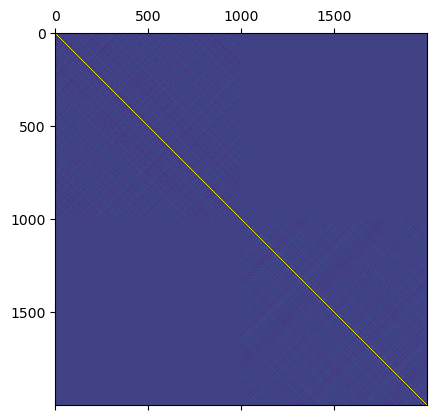

In [14]:
import matplotlib.pyplot as plt

# plt.matshow(Ups_invs[3,:,:])
